# Capstone 2 - Modeling
# Predicting Hospital readmissions within 30 days

Goal: Develop a classification model to predict whether a patient will be readmitted within 30 days of discharge based on clinical and demographic data.

In [6]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 640.0 kB/s eta 0:03:55
   ---------------------------------------- 0.0/150.0 MB 262.6 kB/s eta 0:09:32
   ---------------------------------------- 0.0/150.0 MB 262.6 kB/s eta 0:09:32
   ---------------------------------------- 0.1/150.0 MB 260.9 kB/s eta 0:09:35
   ---------------------------------------- 0.1/150.0 MB 381.3 kB/s eta 0:06:34
   ---------------------------------------- 0.1/150.0 MB 435.7 kB/s eta 0:05:44
   ---------------------------------------- 0.2/150.0 MB 490.7 kB/s eta 0:05:06
   ---------------------------------------- 0.2/150.0 MB 490.7 kB/s eta 0:05:06
   ---------------------------------------- 0.2/150.0 MB 490.7 kB/s eta 0:05:06
   ---------------------------------------- 0.2/150.0 MB 490.7 kB/s eta 0:05:06
   ---------------------------------------- 0.2/150.0 MB 393.0 kB/s eta 0:06:22
   ---------------------------------------- 0.2/1

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [77]:
#load the data
diabetic_data = pd.read_csv(r"C:\Users\aasha\Downloads\diabetic_data_cleaned.csv")

In [79]:
#checking the data to make sure it is wrangled and ready for modeling
diabetic_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary
0,Caucasian,Female,5,6,25,1,Pediatrics-Endocrinology,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,15,1,1,3,0,59,0,18,...,Up,No,No,No,No,No,Yes,Yes,>30,0
2,AfricanAmerican,Female,25,1,1,2,0,11,5,13,...,No,No,No,No,No,No,No,Yes,No,0
3,Caucasian,Male,35,1,1,2,0,44,1,16,...,Up,No,No,No,No,No,Yes,Yes,No,0
4,Caucasian,Male,45,1,1,1,0,51,0,8,...,Steady,No,No,No,No,No,Yes,Yes,No,0


In [81]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99493 entries, 0 to 99492
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      99493 non-null  object
 1   gender                    99493 non-null  object
 2   age                       99493 non-null  int64 
 3   admission_type_id         99493 non-null  int64 
 4   discharge_disposition_id  99493 non-null  int64 
 5   time_in_hospital          99493 non-null  int64 
 6   medical_specialty         99493 non-null  object
 7   num_lab_procedures        99493 non-null  int64 
 8   num_procedures            99493 non-null  int64 
 9   num_medications           99493 non-null  int64 
 10  number_outpatient         99493 non-null  int64 
 11  number_emergency          99493 non-null  int64 
 12  number_inpatient          99493 non-null  int64 
 13  diag_1                    99493 non-null  object
 14  diag_2                

In [99]:
#drop identifiers and target
X = diabetic_data.drop(columns=['readmitted_binary'])
y = diabetic_data['readmitted_binary']                       

In [101]:
#using the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [103]:
#separate column types

num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

#create preprocessing pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])


In [105]:
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [107]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [109]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

In [111]:
models = {
    "Logistic Regression": logreg_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    y_proba = model.predict_proba(X_test)[:, 1]
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))



Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17724
           1       1.00      1.00      1.00      2175

    accuracy                           1.00     19899
   macro avg       1.00      1.00      1.00     19899
weighted avg       1.00      1.00      1.00     19899

Confusion Matrix:
[[17724     0]
 [    0  2175]]
ROC AUC Score: 1.0

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17724
           1       1.00      1.00      1.00      2175

    accuracy                           1.00     19899
   macro avg       1.00      1.00      1.00     19899
weighted avg       1.00      1.00      1.00     19899

Confusion Matrix:
[[17724     0]
 [    0  2175]]
ROC AUC Score: 1.0

XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17724
           1     

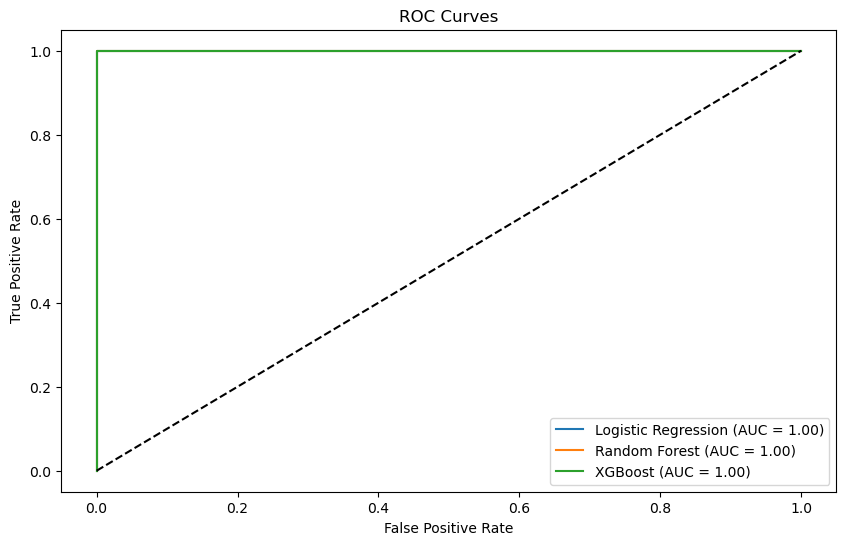

In [115]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
